In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/21_FastGAN_mnist.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# FastGAN
- En este notebook se define y entrena una arquitectura basada en [FastGAN](https://arxiv.org/abs/2101.04775).

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

torch.__version__

'2.0.1+cu117'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 128

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

In [5]:
len(train_loader.dataset)

60000

In [6]:
test_batch, test_labels = next(iter(train_loader))
test_batch.shape, test_labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

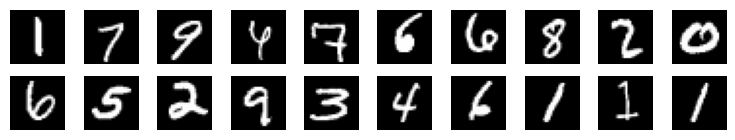

In [7]:
# Define a function to plot images with titles
def plot_batch(images):
    fig, axes = plt.subplots(2, 10, figsize=(7.5, 1.5))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a batch of images and their corresponding targets
n = 20
batch_images = test_batch[:n]

# Plot the batch of images
plot_batch(batch_images)

## 2.- Modelo
### Generador

In [8]:
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_planes, out_planes, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.LeakyReLU(0.2),
        nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.LeakyReLU(0.2)
    )
    return block

In [9]:
class Generator(nn.Module):
    def __init__(self, filters=128, noise_dim=64):
        super(Generator, self).__init__()
        self.filters = filters
        self.init = nn.Sequential(
            nn.Linear(noise_dim, filters * 7 * 7),
            nn.BatchNorm1d(filters * 7 * 7),
            nn.LeakyReLU(0.2),
        )             
        
        self.feat_8   = upBlock(filters, filters)
        self.feat_16  = upBlock(filters, filters // 2)
        self.feat_32  = upBlock(filters // 2, filters // 4)
        
        self.ch_conv = nn.Conv2d(filters // 4, 1, 3, 1, 1, bias=False)

    def forward(self, z):
        feat_8 = self.init(z)
        feat_8 = torch.reshape(feat_8, (-1, self.filters, 7, 7))
        feat_16 = self.feat_16(feat_8)
        feat_32 = self.feat_32(feat_16)

        img = torch.tanh(self.ch_conv(feat_32))
        return img
    
    
noise_dim = 64
noise = torch.randn(batch_size, noise_dim)
generator = Generator(128, noise_dim)
gen_batch = generator(noise)
gen_batch.shape

torch.Size([128, 1, 28, 28])

In [10]:
from torchsummary import summary

In [11]:
summary(generator, (noise_dim,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         407,680
       BatchNorm1d-2                 [-1, 6272]          12,544
         LeakyReLU-3                 [-1, 6272]               0
          Upsample-4          [-1, 128, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          73,728
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         LeakyReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,864
       BatchNorm2d-9           [-1, 64, 14, 14]             128
        LeakyReLU-10           [-1, 64, 14, 14]               0
         Upsample-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 32, 28, 28]          18,432
      BatchNorm2d-13           [-1, 32, 28, 28]              64
        LeakyReLU-14           [-1, 32,

### Discriminador

In [12]:
class DownBlockComp(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlockComp, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True)
        )

        self.direct = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(in_planes, out_planes, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True))

    def forward(self, feat):
        return (self.main(feat) + self.direct(feat)) / 2

In [13]:
class Discriminator(nn.Module):
    def __init__(self, filters=128, noise_dim=64):
        super(Discriminator, self).__init__()
        self.down_from_big = nn.Sequential(
            nn.Conv2d(1, filters // 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(filters // 8), nn.LeakyReLU(0.2, inplace=True),
        )
        self.down_16 = DownBlockComp(filters // 8, filters // 4)
        self.down_8 = DownBlockComp(filters // 4, filters // 2)

        self.logits = nn.Sequential(
            nn.Conv2d(filters // 2, filters, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(filters, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        B = x.shape[0]
        x = self.down_from_big(x)
        x = self.down_16(x)
        x = self.down_8(x)
        x = self.logits(x).view(B, -1)
        return x
    
    
discriminator = Discriminator(128)
out_disc = discriminator(test_batch)
out_disc.shape

torch.Size([128, 16])

In [14]:
summary(discriminator, test_batch.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
         LeakyReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 14, 14]           8,192
       BatchNorm2d-5           [-1, 32, 14, 14]              64
         LeakyReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,216
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         LeakyReLU-9           [-1, 32, 14, 14]               0
        AvgPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]             512
      BatchNorm2d-12           [-1, 32, 14, 14]              64
        LeakyReLU-13           [-1, 32, 14, 14]               0
    DownBlockComp-14           [-1, 32,

## 3.- Entrenamiento

In [15]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [17]:
g_lr = 0.0001
d_lr = 0.0001
beta1 = 0.5
beta2 = 0.9

generator.to(device)
generator.apply(weights_init)
discriminator.to(device)
discriminator.apply(weights_init)
g_optimizer = optim.Adam(generator.parameters(), lr=g_lr, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(beta1, beta2))

loss_fn = nn.BCELoss()

In [18]:
def generator_loss(fake_output, batch_size, device):
    real_labels = torch.ones((batch_size, 16)).to(device)
    return loss_fn(fake_output, real_labels)

In [19]:
def discriminator_loss(real_output, fake_output, batch_size, device):
    real_labels = torch.ones((batch_size, 16)).to(device)
    fake_labels = torch.zeros((batch_size, 16)).to(device)
    real_loss = loss_fn(real_output, real_labels)
    fake_loss = loss_fn(fake_output, fake_labels)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
epochs = 25
plot_inter = 5

def train(generator, discriminator, g_opt, d_opt, data_loader, 
          loss_fn, epochs, plot_inter, device):

    for epoch in range(epochs):
        g_loss_avg = 0.0
        d_loss_avg = 0.0
        start = time.time()
        generator.train()
        discriminator.train()
        for real_img, _ in data_loader:
             # Train the generator
            real_img = real_img.to(device)
            real_img = 2.0 * real_img - 1.0
            
            generator.zero_grad()
            batch_size = real_img.shape[0]
            noise = torch.randn(batch_size, noise_dim, device=device)

            gen_img = generator(noise)
            fake_out = discriminator(gen_img)

            g_loss = generator_loss(fake_out, batch_size, device)
            g_loss.backward()
            g_opt.step()

            # Train the discriminator
            discriminator.zero_grad()
            real_out = discriminator(real_img)
            fake_out = discriminator(gen_img.detach())

            d_loss = discriminator_loss(real_out, fake_out, batch_size, device)
            d_loss.backward()
            d_opt.step()
            
            # Metrics
            g_loss_avg += g_loss.item()
            d_loss_avg += d_loss.item()

        g_loss_avg /= len(data_loader)
        d_loss_avg /= len(data_loader)

        if epoch % plot_inter == 0:
            print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec G loss: {g_loss_avg:.4f} D loss: {d_loss_avg:.4f}')
            generator.eval()
            noise = torch.randn(n, noise_dim, device=device)
            
            gen_batch = generator(noise).detach().cpu()
            plot_batch(gen_batch)

Time for epoch 0 is 6.4975 sec G loss: 1.5436 D loss: 0.7987


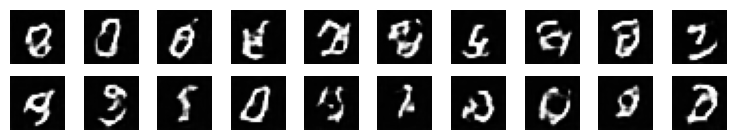

Time for epoch 5 is 5.5856 sec G loss: 1.4660 D loss: 0.8971


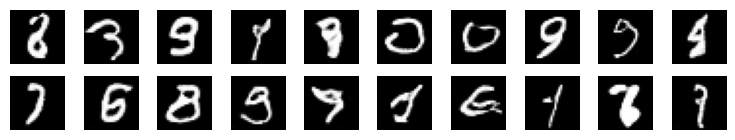

Time for epoch 10 is 5.4725 sec G loss: 1.4735 D loss: 0.8854


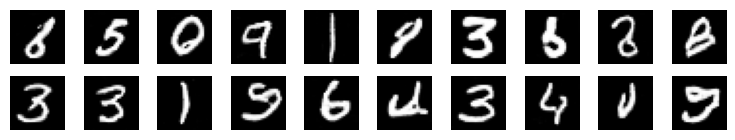

Time for epoch 15 is 5.7653 sec G loss: 1.4637 D loss: 0.9043


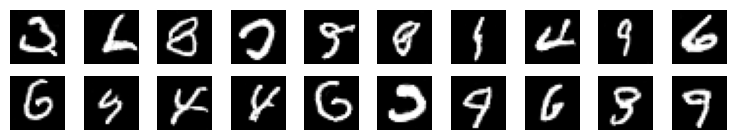

Time for epoch 20 is 5.6383 sec G loss: 1.4382 D loss: 0.9213


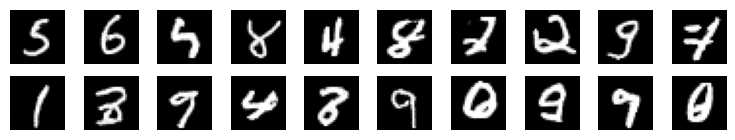

In [21]:
train(generator, discriminator, g_optimizer, d_optimizer, 
        train_loader, loss_fn, epochs, plot_inter, device)

## Ejercicio
- Convierte al modelo a una [GAN condicionada](https://arxiv.org/abs/1411.1784). En este modelo, el generador y el discriminador reciben un vector de etiqueta:

\begin{equation}
V(G, D) = \mathbb{E}_{x \sim p_{\text{r}}(x|y)}[\log D(x|y)] + \mathbb{E}_{z \sim p_{z}(z)}[\log (1 - D(G(z|y)))]
\end{equation}